## Project 1

Start Date: Jan 27 2025

In [1]:
#Imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from itertools import combinations
from datetime import datetime
from collections import defaultdict, Counter

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, RFECV, SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.compose import ColumnTransformer

from hyperopt import fmin, tpe,rand, hp, STATUS_OK,space_eval, Trials
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC

from xgboost import plot_importance
from xgboost import plot_tree
#import shap


In [2]:
# Checking pythin installation path
import os, sys
os.path.dirname(sys.executable)

'd:\\Installations\\Python'

In [3]:
# Load the data
df = pd.read_csv("data/ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
print(df.isna().sum())
print(df.isnull().sum())

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64
Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64


In [5]:
#seed = random.randint(1000, 9999)
seed = 3543#1311 #3717#7739 , 4964, 3717 (best, good recall AND precision), | 3874, 8013 (best acc for bernoulli NB) | 1311 (best for LGBM)
np.random.seed(seed)
random.seed(seed)
print(seed)

3543


In [6]:
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
X = df[features]
Y = df['Y']

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Print the shapes of the resulting sets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 6) (26, 6) (100,) (26,)


In [7]:
# Setting 'unhappy' as the positive class
def recall_func(y_test, y_pred):
    return recall_score(y_test, y_pred, pos_label=0)

## Model selection

In [8]:
# # Lazy Predict helps with setting a baseline.
# # Running lazy predict multiple times with different random seeds to see the behavior.
# # Note that a well trained stable model's output should not depend on the seed. Here, the outcome varies because the models are not tuned to the dataset.
# # This code block is to get an idea about which models would perform best with the dataset.

# # Number of iterations
# num_iterations = 50

# # Dictionary to store top 10 models per iteration
# top_models_per_iteration = []

# # Dictionary to store best accuracy and corresponding seed for each model
# best_seeds = defaultdict(lambda: (0, None))

# for _ in range(num_iterations):
#     # Split data with different random seed
#     seed = random.randint(1000, 9999)
#     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
    
#     # Initialize LazyClassifier
#     clf = LazyClassifier(verbose=0, predictions=False,ignore_warnings=True, custom_metric=recall_func)
    
#     # Fit and evaluate models
#     models, _ = clf.fit(x_train, x_test, y_train, y_test)
    
#     # Get top 10 models for this iteration
#     top_10_models = models.head(5).index.tolist()
#     top_models_per_iteration.extend(top_10_models)
    
#     # Record best accuracy and corresponding seed
#     for model_name, row in models.iterrows():
#         accuracy = row['recall_func']
#         if accuracy > best_seeds[model_name][0]:
#             best_seeds[model_name] = (accuracy, seed)

# # Count occurrences of each model in the top 10
# model_counts = Counter(top_models_per_iteration)

# # Get the three most frequently appearing models
# best_models = model_counts.most_common(3)

# # Display results
# print("Top 3 Most Frequently Appearing Models in Top 5:")
# for model, count in best_models:
#     best_accuracy, best_seed = best_seeds[model]
#     print(f"{model}: {count} times, Best Accuracy: {best_accuracy:.4f}, Best Seed: {best_seed}")


In [9]:
# Baselines
# LazyClassifier runs all models using their default settings. 
# Use this to get a sense of the top performing models and then finetune them.
# We are more interested predicting the unhappy class (class 0) correctly. So, we make it the positive class.
# We should improve recall. So, we select the best models based on recall. 
# F1 score is a combination of recall and precision. 


clf = LazyClassifier(verbose=-1,ignore_warnings=True, custom_metric=recall_func, predictions=True, random_state=seed)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

models

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

100%|██████████| 29/29 [00:01<00:00, 22.89it/s]

[LightGBM] [Info] Number of positive: 53, number of negative: 47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530000 -> initscore=0.120144
[LightGBM] [Info] Start training from score 0.120144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_func,Time Taken
Model,,,,,,
BernoulliNB,0.88,0.91,0.91,0.89,1.00,0.03
AdaBoostClassifier,0.77,0.76,0.76,0.77,0.70,0.13
LinearDiscriminantAnalysis,0.73,0.72,0.72,0.73,0.70,0.01
RidgeClassifierCV,0.73,0.72,0.72,0.73,0.70,0.02
RidgeClassifier,0.73,0.72,0.72,0.73,0.70,0.00
LogisticRegression,0.73,0.72,0.72,0.73,0.70,0.01
LinearSVC,0.73,0.72,0.72,0.73,0.70,0.02
NearestCentroid,0.69,0.71,0.71,0.70,0.80,0.02
PassiveAggressiveClassifier,0.73,0.71,0.71,0.73,0.60,0.01


In [10]:
# Some Sklearn models do not have feature importance function.
# So, wrappers for those classifiers were created.
class MyBaggingClassifier(BaggingClassifier):
    @property
    def feature_importances_(self):
        feature_importances = np.mean([
            tree.feature_importances_ for tree in self.estimators_], axis=0)
        
        return feature_importances
    
class MyBernoulliNB(BernoulliNB):
    @property
    def feature_importances_(self):
        # Compute feature importance as absolute difference in log probabilities
        return np.abs(self.feature_log_prob_[1] - self.feature_log_prob_[0])

In [11]:
# Data pre-processing steps
preprocessor = Pipeline(
    steps=[("scaler", StandardScaler())] #("imputer", SimpleImputer(strategy="mean")), 
)

Based on LazyPredictor results, three classifiers were selected. The three models can be categorized into 3 categories:
- BernoulliNB - probabilistic
- AdaBoost - ensemble method
- LinearSVC - linear model 

   Accuracy  Recall  Precision
0      0.88    1.00       0.77
1      0.77    0.70       0.70
2      0.73    0.70       0.64


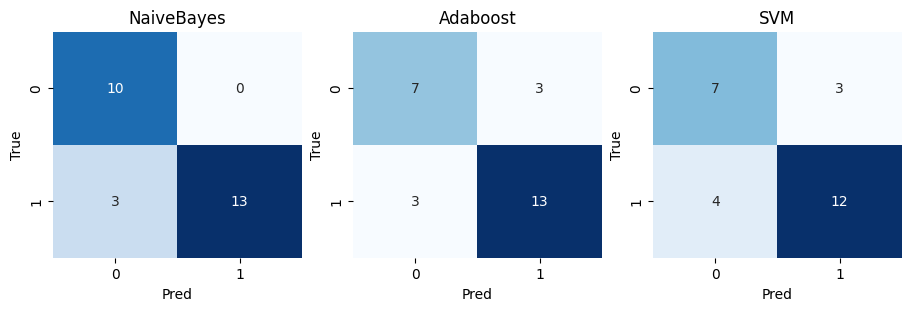

In [12]:
# Re-training the selected models

# seed = 3543#random.randint(1000, 9999)
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

classifiers = {
    'NaiveBayes': MyBernoulliNB(),#MyBernoulliNB(),
    'Adaboost': AdaBoostClassifier(random_state=seed),
    'SVM': LinearSVC(random_state=seed)
}


fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", clf)
    ])

    model.fit(x_train, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred,normalize=True)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    #importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])

print(metrics_df)
#print(importance_df)
plt.show()

## Feature selection

Since the dataset is small, we can do an exhaustive search of all feature combinations.

In [13]:
# Defining recall with unhappy class as the positive class as the scoring function
def my_scorer(estimator, x, y):
    
    y_pred = estimator.predict(x)
    score = recall_score(y, y_pred, pos_label=0)

    return score

#### Two methods
1. Exhaustively searching the whole feature space by considering every feature combination
1. Recursive feature elimination with cross validation

The first method is in-efficient and time consuming.
With the second method, we can use cross validation to determine the optimal number of features required.

In [ ]:
## Feature-wise classification
results = {clf_name:[] for clf_name in classifiers.keys()}
loo = LeaveOneOut()

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    best_combinations = []
    for i in range(1, len(features)+1):
        for combo in combinations(features, i):
            X_subset = df[list(combo)]
            x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

            model = Pipeline([
                ("preprocessing", preprocessor),
                ("classifier", clf)
            ])

            scores = cross_val_score(model, x_train_subset, y_train, cv=loo, scoring=my_scorer)
            avg_score = np.mean(scores)
            model.fit(x_train_subset, y_train)

            # Make predictions
            y_pred = model.predict(x_test_subset)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, pos_label=0)
            recall = recall_score(y_test, y_pred, pos_label=0)

            best_combinations.append((combo, avg_score, accuracy, recall, precision))
    
    best_combinations.sort(key=lambda x:x[1], reverse=True)
    results[clf_name] = best_combinations[:3]

final_result = []

for clf_name, top_combos in results.items():
    for combo, score, acc, recall, precision in top_combos:
        final_result.append({'Classifier':clf_name, 'Features':combo, 'Cross-val Score':score, 'Accuracy':acc, 'Precision':precision, 'Recall':recall})

final_df = pd.DataFrame(final_result)
print(final_df)
            
        

In [14]:
## Feature-wise classification
results = {clf_name:[] for clf_name in classifiers.keys()}
loo = LeaveOneOut()
for idx, (clf_name, clf) in enumerate(classifiers.items()):

    print(f"Processing: {clf_name}")

    if clf_name == '888':#'NaiveBayes':
        # Use SelectKBest for Naïve Bayes
        # Naïve Bayes assumes feature independence. Thus, feature importances may not be suitable for feature selection
        feature_selector = SelectKBest(lambda X, y: mutual_info_classif(X, y, random_state=seed), k=4)
        model = Pipeline([
            ("preprocessing", preprocessor),
            ("feature_selection", feature_selector),
            ("classifier", clf)
        ])
    else:
        # Use RFE for other classifiers
        #rfe = RFE(clf, n_features_to_select=3)
        rfecv = RFECV(estimator=clf, step=1, cv=loo, scoring=my_scorer, n_jobs=-1)
        model = Pipeline([
            ("preprocessing", preprocessor),
            ("feature_selection", rfecv),
            ("classifier", clf)
        ])

    model.fit(x_train, y_train)

    # Print ranking of features
    if clf_name == '888':# 'NaiveBayes':
        selected_features = np.array(features)[feature_selector.get_support()]
        print(f"{clf_name} Selected Features: {selected_features}")
    else:
        # ranking = pd.DataFrame({'Feature': features, 'Ranking': rfe.ranking_})
        # print(f"{clf_name} \n {ranking}")
        selected_features = np.array(features)[rfecv.support_]
        print(f"Optimal Number of Features: {rfecv.n_features_}")
        print(f"Selected Features: {selected_features}")
        

Processing: NaiveBayes
Optimal Number of Features: 1
Selected Features: ['X1']
Processing: Adaboost
Optimal Number of Features: 6
Selected Features: ['X1' 'X2' 'X3' 'X4' 'X5' 'X6']
Processing: SVM
Optimal Number of Features: 5
Selected Features: ['X1' 'X2' 'X3' 'X5' 'X6']


In [ ]:
rfecv.cv_results_

   Accuracy  Recall  Precision
0      0.85    0.80       0.80
1      0.77    0.70       0.70
2      0.73    0.70       0.64


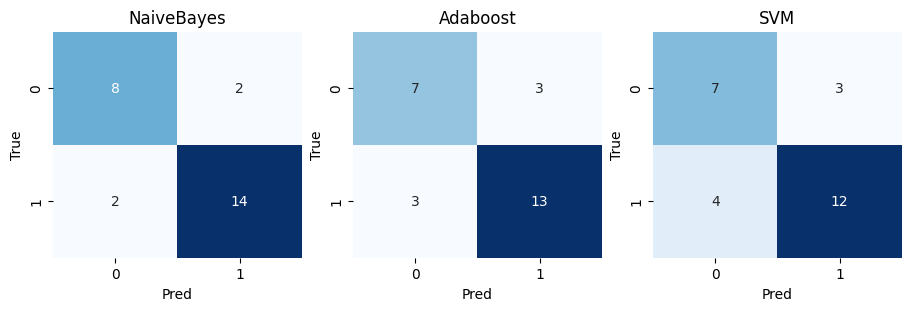

In [15]:
## Evaluating feature selection
features_subset = [['X1'],#['X1', 'X3', 'X4', 'X5'], #['X2', 'X3', 'X4', 'X6']
                   ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'],#['X1', 'X2', 'X3', 'X5', 'X6'], #['X1', 'X2', 'X5', 'X6']
                    ['X1', 'X2', 'X3', 'X5', 'X6']] #['X1', 'X3', 'X5', 'X6']

fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
metrics = []
importances = []
for idx, (clf_name, clf) in enumerate(classifiers.items()): 
    X_subset = df[features_subset[idx]]
    x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

    model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
        ])


    model.fit(x_train_subset, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = model.predict(x_test_subset)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    # importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)
plt.show()

## Hyperparameter tuning


In [16]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# Define early stopping function
def early_stop_fn(trials):
    threshold=5
    if len(trials.trials) < threshold:
        return False  # Not enough trials to compare

    # Extract loss values from past trials
    losses = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    
    if len(losses) < threshold:
        return False  # Ensure we have enough loss values

    best_loss_before = min(losses[:-threshold])  # Best loss before recent threshold
    best_loss_now = min(losses)  # Current best loss

    return best_loss_now >= best_loss_before  # Stop if no improvement

In [17]:
# Naive Bayes hyperparameter tuning with HyperOpt
loo = LeaveOneOut()
best_params_all = {}

X_subset = df[features_subset[0]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    clf = MyBernoulliNB(**params)
    model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
    ])

    score = cross_val_score(model, x_train_subset, y_train, cv=loo, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'alpha': hp.loguniform('alpha', -5, 2),  # alpha ∈ (exp(-5), exp(2)) ≈ (0.0067, 7.39)
    'fit_prior': hp.choice('fit_prior', [True, False]),  # Boolean choice
    'binarize': hp.uniform('binarize', 0, 1)  # Feature binarization threshold
}
# Run the optimization
starttime = timer()
best_params = fmin(objective, space, algo=rand.suggest, max_evals=500, early_stop_fn=no_progress_loss(10), rstate=np.random.default_rng(seed))
timer(starttime)

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)
best_params_all['NaiveBayes'] = best_params

# Evaluate the model with the best hyperparameters
final_clf = MyBernoulliNB(**best_params)
final_model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", final_clf)
])


final_model.fit(x_train_subset, y_train)
# accuracy = final_model.score(x_test_subset,y_test)
# print("Accuracy:", accuracy)

y_pred = final_model.predict(x_test_subset)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
metrics = []
metrics.append([accuracy, recall, precision])

# importances.append(clf.feature_importances_)

cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)
plt.show()


  2%|▏         | 10/500 [00:08<06:43,  1.21trial/s, best loss: -0.29]

 Time taken: 0 hours 0 minutes and 8.24 seconds.
Best hyperparameters: {'alpha': 0.16297875749314045, 'binarize': 0.2807385382126685, 'fit_prior': True}
   Accuracy  Recall  Precision
0      0.85    0.80       0.80


In [29]:
# AdaBoost hyperparameter tuning with HyperOpt

X_subset = df[features_subset[1]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")

    # # Create the base estimator separately
    # estimator = DecisionTreeClassifier(
    #     max_depth=params.pop('max_depth'),
    #     min_samples_split=params.pop('min_samples_split'),
    #     random_state=seed
    # )

    clf = AdaBoostClassifier(**params, random_state=seed) #estimator=estimator,
 
    model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
    ])

    score = cross_val_score(model, x_train_subset, y_train, cv=loo, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 10)),  # Number of boosting rounds
    'learning_rate': hp.loguniform('learning_rate', -4, 0),  # Learning rate (0.0001 to 1)
    'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R']),  # Type of boosting
    #'max_depth': scope.int(hp.quniform('base_max_depth', 1, 30, 1)),  # Depth of weak learners
    #'min_samples_split': hp.uniform('base_min_samples_split', 0.01, 0.5),  # Min samples per split
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500, early_stop_fn=no_progress_loss(10), rstate=np.random.default_rng(seed))

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)
best_params_all['AdaBoost'] = best_params

# Evaluate the model with the best hyperparameters
best_params['n_estimators'] = int(best_params['n_estimators'])
#best_params['max_depth'] = int(best_params['max_depth'])

# estimator = DecisionTreeClassifier(
#         max_depth=best_params.pop('max_depth'),
#         min_samples_split=best_params.pop('min_samples_split'),
#         random_state=seed
#     )

final_clf = AdaBoostClassifier(**best_params, random_state=seed) #estimator=estimator, 

final_model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", final_clf)
])


final_model.fit(x_train_subset, y_train)
# accuracy = final_model.score(x_test_subset,y_test)
# print("Accuracy:", accuracy)

y_pred = final_model.predict(x_test_subset)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
metrics = []
metrics.append([accuracy, recall, precision])

# importances.append(clf.feature_importances_)

cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)
plt.show()


  3%|▎         | 14/500 [03:51<2:13:57, 16.54s/trial, best loss: -0.22]
Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.3502049947378976, 'n_estimators': 50}
   Accuracy  Recall  Precision
0      0.85    0.80       0.80


In [ ]:
# LinearSVC hyperparameter tuning with HyperOpt

X_subset = df[features_subset[2]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    clf = LinearSVC(**params, random_state=seed)
    model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
    ])

    score = cross_val_score(model, x_train_subset, y_train, cv=loo, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'C': hp.loguniform('C', -5, 2),  # Regularization strength (10^-5 to 10^2)
    'loss': hp.choice('loss', ['hinge', 'squared_hinge']),  # Loss function
    'tol': hp.loguniform('tol', -6, -2),  # Stopping tolerance (10^-6 to 10^-2)
    'max_iter': scope.int(hp.quniform('max_iter', 500, 5000, 100)),  # Number of iterations
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500, early_stop_fn=no_progress_loss(10), rstate=np.random.default_rng(seed)) #rand

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)
best_params_all['SVM'] = best_params

# Evaluate the model with the best hyperparameters

best_params['max_iter'] = int(best_params['max_iter'])

final_clf = LinearSVC(**best_params, random_state=seed)
final_model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", final_clf)
])


final_model.fit(x_train_subset, y_train)
# accuracy = final_model.score(x_test_subset,y_test)
# print("Accuracy:", accuracy)

y_pred = final_model.predict(x_test_subset)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
metrics = []
metrics.append([accuracy, recall, precision])

# importances.append(clf.feature_importances_)

cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)


  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

  4%|▍         | 19/500 [00:14<06:17,  1.27trial/s, best loss: -0.2]
Best hyperparameters: {'C': 0.013433227072091682, 'loss': 'hinge', 'max_iter': 4500, 'tol': 0.0500466063883078}
   Accuracy  Recall  Precision
0      0.69    0.60       0.60


   Accuracy  Recall  Precision
0      0.85    0.80       0.80
1      0.85    0.80       0.80
2      0.69    0.60       0.60


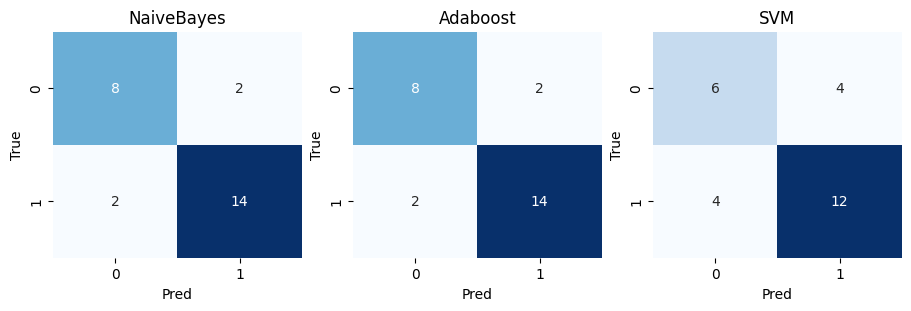

In [30]:
# Re-training the selected models

seed = 3543 #random.randint(1000, 9999) #
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

classifiers = {
    'NaiveBayes': MyBernoulliNB(**best_params_all['NaiveBayes']),#MyBernoulliNB(),
    'Adaboost': AdaBoostClassifier(**best_params_all['AdaBoost'], random_state=seed),
    'SVM': LinearSVC(**best_params_all['SVM'], random_state=seed)
}


fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    X_subset = df[features_subset[idx]]
    x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

    model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", clf)
    ])

    model.fit(x_train_subset, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = model.predict(x_test_subset)

    accuracy = accuracy_score(y_test, y_pred,normalize=True)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    #importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])

# importance_df = pd.DataFrame(
#     {
#         'Features': features,
#         'NaiveBayes': importances[0],
#         'LGBM': importances[1],
#         'XGBoost': importances[2]
#     }
# )
print(metrics_df)
#print(importance_df)
plt.show()

In [31]:
classifiers = {
    'NaiveBayes': MyBernoulliNB(**best_params_all['NaiveBayes']),#MyBernoulliNB(),
    'Adaboost': AdaBoostClassifier(**best_params_all['AdaBoost'], random_state=seed),
    'SVM': LinearSVC(**best_params_all['SVM'], random_state=seed)
}

# Number of trials
num_trials = 20  
performance_results = {clf: [] for clf in classifiers}

# Run multiple trials with different seeds
for _ in range(num_trials):
    seed = random.randint(1000, 9999)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
    
    for clf_name, clf in classifiers.items():

        model = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", clf)
        ])

        
        model.fit(x_train, y_train)  # Train with fixed hyperparameters
        y_pred = model.predict(x_test)

        # Compute performance metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, pos_label=0),
            "recall": recall_score(y_test, y_pred, pos_label=0),
        }
        
        performance_results[clf_name].append(metrics)

# Compute mean and standard deviation for each model
summary_results = []
for clf_name, metrics_list in performance_results.items():
    df_metrics = pd.DataFrame(metrics_list)
    mean_metrics = df_metrics.mean()
    std_metrics = df_metrics.std()
    
    summary_results.append({
        "Model": clf_name,
        "Mean Accuracy": mean_metrics["accuracy"],
        "Std Accuracy": std_metrics["accuracy"],
        "Mean Recall": mean_metrics["recall"],
        "Std Recall": std_metrics["recall"]
    })

# Convert results to DataFrame
df_results = pd.DataFrame(summary_results)
df_results = df_results.sort_values(by="Mean Recall", ascending=False)

# Display final ranking of models
print(df_results)

        Model  Mean Accuracy  Std Accuracy  Mean Recall  Std Recall
1    Adaboost           0.57          0.09         0.51        0.15
0  NaiveBayes           0.58          0.10         0.49        0.13
2         SVM           0.55          0.08         0.40        0.11


In [ ]:
clf.get_params()

## Voting and stacking 

In [26]:
# clf1 = MyBernoulliNB(**best_params_all['NaiveBayes'])
# clf2 = AdaBoostClassifier(**best_params_all['AdaBoost'], random_state=seed)
# clf3 = LinearSVC(**best_params_all['SVM'], random_state=seed)

seed = seed = 3543#random.randint(1000,9999)
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

y_preds = {}

# Hard voting 
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf1 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)],voting='hard')

model1 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf1)
])

model1.fit(x_train, y_train)
y_preds['hard'] = model1.predict(x_test)

# Soft voting
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf2 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)], voting='soft')

model2 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf2)
])

model2.fit(x_train, y_train)
y_preds['soft'] = model2.predict(x_test)

# Soft voting with weights
clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

eclf3 = VotingClassifier(estimators=[('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)], voting='soft', weights=[2, 1, 1])

model3 = Pipeline([
            ("preprocessing", preprocessor),
            ("classifier", eclf3)
])

model3.fit(x_train, y_train)
y_preds['weighted'] = model3.predict(x_test)

# Print accuracy scores
metrics = []
for model_name, preds in y_preds.items():

    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, pos_label=0)
    recall = recall_score(y_test, preds, pos_label=0)

    metrics.append([accuracy, recall, precision])

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)

# for clf, label in zip([clf1, clf2, clf3, eclf], ['Naive Bayes', 'AdaBoost ', 'LinearSVC', 'Ensemble']):
#     scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

   Accuracy  Recall  Precision
0      0.85    0.90       0.75
1      0.88    0.90       0.82
2      0.88    0.90       0.82


In [28]:
# Stacking classifier

clf1 = MyBernoulliNB()
clf2 = AdaBoostClassifier(random_state=seed)
clf3 = SVC(random_state=seed, probability=True)

# Define the base models
estimators = [('nb', clf1), ('aboost', clf2), ('lnsvc', clf3)]
final_estimator = XGBClassifier(random_state=seed)

eclf4 = StackingClassifier(estimators=estimators,final_estimator=final_estimator,cv=6)
eclf4.fit(x_train, y_train)
y_pred = eclf4.predict(x_test)

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, pos_label=0)
recall = recall_score(y_test, preds, pos_label=0)

metrics = [[accuracy, recall, precision]]
metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)

   Accuracy  Recall  Precision
0      0.88    0.90       0.82


In [ ]:
# ## Finetuning XGBoost to reduce overfitting


# features_subset = ['X1', 'X3', 'X4', 'X6'] # Common feature set for all three models
# X_subset = df[features_subset]
# x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# # A parameter grid for XGBoost
# params = {
#         'min_child_weight': [1, 5, 10], #Larger -> more conservative model (i.e. less splitting)
#         'gamma': [0, 0.5, 1, 1.5, 2, 5], #Larger -> more conservative model (i.e. less splitting)
#         'max_depth': [3, 4, 5, 6] #Smaller -> mpre conservative model
#         }

# skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = seed)
# kf = KFold(n_splits=10, shuffle = True, random_state = seed)

# grid = GridSearchCV(estimator=classifiers['Bagging'], param_grid=params, scoring=my_scorer, n_jobs=4, cv=kf.split(x_train_subset,y_train), verbose=3, error_score='raise')

# starttime = timer()
# grid.fit(x_train_subset, y_train)
# timer(starttime)

# print('\n All results:')
# print(grid.cv_results_)
# print('\n Best estimator:')
# print(grid.best_estimator_)
# print('\n Best score:')
# print(grid.best_score_ )#print(grid.best_score_ * 2 - 1)
# print('\n Best parameters:')
# print(grid.best_params_)
# results = pd.DataFrame(grid.cv_results_)
# results.to_csv('xgb-grid-search-results-01.csv', index=False)

# y_pred = grid.best_estimator_.predict(x_test_subset)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, pos_label=0)
# recall = recall_score(y_test, y_pred, pos_label=0)

# print(f'Accuracy = {accuracy:0.2f}, Precision = {precision:0.2f}, Recall = {recall:0.2f}')

# # y_test = grid.best_estimator_.predict_proba(x_test_subset)
# # results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
# # results_df.to_csv('submission-grid-search-xgb-porto-01.csv', index=False)



GridSearchCV does not give the best test scores. Default settings give better test scores. But, train cross validation scores vary largely and they are higher for the hyperparameters given by the grid search.
High variability of cross validation scores and descrepancy between train and test scores could be because the model has not been fit well or the training set is not generalizing well. 

In [ ]:
# Initialize StratifiedKFold for maintaining class distribution in each fold
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#kf = KFold(n_splits=10, shuffle=True, random_state=seed)
# Visualize the distributions
# fold_number = 1
# for train_index, test_index in kf.split(x_train_subset, y_train):
#     fold_df = df.iloc[test_index]
    
#     # Plot class distribution
#     plt.figure(figsize=(10, 4))
    
#     plt.subplot(1, 2, 1)
#     sns.countplot(x='Y', data=fold_df)
#     plt.title(f'Class Distribution - Fold {fold_number}')
#     plt.xlabel('Class')
#     plt.ylabel('Count')
    
#     # Plot feature distribution (for the first feature as an example)
#     plt.subplot(1, 2, 2)
#     sns.histplot(fold_df['X3'], kde=True, bins=10)
#     plt.title(f'Feature Distribution (X3) - Fold {fold_number}')
#     plt.xlabel('Feature Value')
#     plt.ylabel('Count')
    
#     plt.tight_layout()
#     plt.show()
    
#     fold_number += 1

In [ ]:
# LGBM optimization with HyperOpt

X_subset = df[features_subset[1]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    model = LGBMClassifier(**params, verbose=-1)
    score = cross_val_score(model, x_train_subset, y_train, cv=3, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 32, 2)),  # Small range to avoid overfitting
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 5, 50, 5)),  # Prevent too small leaves
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # 0.001 to 1.0
    'max_depth': hp.choice('max_depth', [-1, 3, 5, 7]),  # Limit depth for small dataset
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Feature selection
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Row sampling for regularization
    'reg_alpha': hp.loguniform('reg_alpha', -4, 1),  # L1 regularization (0.0001 to 10)
    'reg_lambda': hp.loguniform('reg_lambda', -4, 1),  # L2 regularization (0.0001 to 10)
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),  # Limit estimators for small dataset
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf']),  # Try both methods
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)


# Evaluate the model with the best hyperparameters
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
best_params['n_estimators'] = int(best_params['n_estimators'])

final_model = LGBMClassifier(**best_params, random_state=seed)
final_model.fit(x_train_subset, y_train)
# accuracy = final_model.score(x_test_subset,y_test)
# print("Accuracy:", accuracy)

y_pred = clf.predict(x_test_subset)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
metrics = []
metrics.append([accuracy, recall, precision])

# importances.append(clf.feature_importances_)

cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)


In [ ]:
# XGBoost optimization with HyperOpt

X_subset = df[features_subset[1]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    model = XGBClassifier(**params, verbose=-1)
    score = cross_val_score(model, x_train_subset, y_train, cv=3, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    'learning_rate': hp.loguniform('learning_rate', -4, 0),  # ~0.0001 to 1
    'max_depth': hp.choice('max_depth', [2, 3, 4, 5, 6, 7, 8, 9]),  # Integer selection
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),  # Integer 50-300 in steps of 10
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Use 50-100% of data per round
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Use 50-100% of features per tree
    'gamma': hp.loguniform('gamma', -5, 1),  # ~0.0067 to 2.71
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),  # L1 regularization ~0.0067 to 2.71
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),  # L2 regularization ~0.0067 to 7.39
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
best_params['n_estimators'] = int(best_params['n_estimators'])

final_model = XGBClassifier(**best_params, random_state=seed)
final_model.fit(x_train_subset, y_train)
accuracy = final_model.score(x_test_subset,y_test)
print("Accuracy:", accuracy)

In [ ]:
final_model.estimator_.get_params()

Decision tree gives the highest recall and accuracy.
XGBoost and ExtraTrees are ensemble models. They could be overfitting. Especially when some features are removed. 

Overfitting is somewhat evident for XGBoost, but not for ExtraTrees. 
We need to finetune the models to reduce overfitting.
We can use `GridSearchCV` (exhaustively looking at all hyperparameter combinations) here because the dataset is small. If the dataset is large, we can use `RandomSearch`.
Note that this is automated hyperparameter tuning. So, cross validation is used here. Cross-validation DOES NOT train the model. It is used to evaluate the current model by fitting the model on part of the training data and VALIDATING on the other part. After validating, if the performance is satisfactory, we fit the model on the entire training set and test on the test partition.

In [ ]:
## Check overfitting using ROC curves

features_subset = ['X1', 'X3', 'X4', 'X5'] # Common feature set for all three models
X_subset = df[features_subset]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    
    clf.fit(x_train_subset, y_train)

    y_probs_train = clf.predict_proba(x_train_subset)[:,0] # Positive class is 0
    y_probs_test = clf.predict_proba(x_test_subset)[:,0] # Positive class is 0

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_probs_train, pos_label=0)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test, pos_label=0)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    ax[idx].plot(fpr_train, tpr_train, 'b', label='Train AUC = {:0.2f}'.format(roc_auc_train))
    ax[idx].plot(fpr_test, tpr_test, 'r', label='Test AUC = {:0.2f}'.format(roc_auc_test))
    ax[idx].legend()
    ax[idx].set_title(clf_name)
    ax[idx].set_xlabel('FPR')
    ax[idx].set_ylabel('TPR')

plt.show()